# Tashkent Accessibility Analysis with Floods

- This analysis will measure accessibility to schools and hospitals
- origins are derived from 250m grid blocks coming from GHSL POP
- the accessibility measure is the time to the nearest facility in seconds

## Inputs:

#### origins: derived from a GHSL POP raster (WorldPop did not visually seem as accurate) manually using the 'Raster pixels to Points' tool in QGIS 3, and saved as a shapefile
#### destinations: The combination of POIs from Overpass as points and centroids of polygons called through the GOSTNets OSMNX_POIs library.
#### The admin AOI will be used to create a bounding box to download the road network via OSMNX


### Import libraries

In [93]:
import sys, os, inspect, logging, importlib

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.ops import split, unary_union
from shapely.geometry import box, Point

import matplotlib.pyplot as plt

In [94]:
# Get reference to OSMNX_POIs
sys.path.append(r'../..')
from Market_Access import OSMNX_POIs

In [95]:
# Get reference to GOSTNets
sys.path.append(r'../../GOSTNets/GOSTNets')
import GOSTnet as gn

In [96]:
# define output folder
inputFolder = r'input_folder'
# define output folder
outputFolder = r'../../../tashkent_output_folder'
# define road graph
roadGraph = os.path.join(inputFolder, "OSM_Roads.pickle")

In [97]:
# import extent
city_extent = gpd.read_file(os.path.join(inputFolder, "Tashkent_AOI.shp"))

In [98]:
# make sure crs is 4326
print(city_extent.crs)

{'init': 'epsg:4326'}


In [99]:
extent = box(*city_extent.total_bounds)

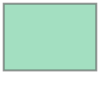

In [100]:
extent

## We will extract OSM POIs

In [101]:
educational_query = OSMNX_POIs.AmenityObject('Education', extent, ['school', 'kindergarten','university', 'college'], inputFolder)        

In [102]:
educational_query

In [103]:
destinations = educational_query.GenerateOSMPOIs()

## We will extract the Roads and convert into a graph, and calculate edge times

In [107]:
# This is the section where we can adjust the road speeds
if not os.path.exists(roadGraph):
    extent = box(*city_extent.total_bounds)
    G = ox.graph_from_polygon(extent, network_type = 'drive_service')
    # This is how time is calculated from the OSMNX length attribute
    G = gn.convert_network_to_time(G, 'length')
    # save the largerst subgraph
    list_of_Gs = list((nx.strongly_connected_component_subgraphs(G)))
    sz = 0
    largest_G = list_of_Gs[0]
    for g in list_of_Gs:
        curSize = g.size()
        if curSize > sz:
            largest_G = g
            sz = curSize
    G = largest_G
    print('print G')
    print(sz)
    nx.write_gpickle(G, roadGraph)
else:
    G = nx.read_gpickle(roadGraph)    
    G = gn.convert_network_to_time(G, 'length')

### Inspect the road graph as a shapefile

In [108]:
roads = gn.edge_gdf_from_graph(G)

In [109]:
roads[:2]

,stnode,endnode,length,time,maxspeed,lanes,access,ref,mode,name,oneway,bridge,service,width,junction,osmid,tunnel,highway,landuse,geometry
0,5814616064,5814616062,69.206,12.45708,NaN,NaN,NaN,NaN,drive,NaN,False,NaN,NaN,NaN,NaN,614769586,NaN,service,NaN,"LINESTRING (69.29000689999999 41.3094792, 69.2..."
1,5814616064,5957852995,25.864,4.65552,NaN,NaN,NaN,NaN,drive,NaN,False,NaN,NaN,NaN,NaN,614769586,NaN,service,NaN,"LINESTRING (69.29000689999999 41.3094792, 69.2..."


In [110]:
if not os.path.exists(outputFolder + '/OSM_Roads/OSM_Roads.shp'):
    roads['oneway'] = roads.oneway.astype(int)
    roads = roads[['oneway','length','time','mode','geometry']]
    roads.to_file(outputFolder + '/OSM_Roads')

# 1st Analysis: Non-flooded scenario

## Create origins and destinations and snap them to the road graph

In [111]:
# insert origins
origins = gpd.read_file(os.path.join(inputFolder, "tashkent_ghsl2015_pop_250m_pts.shp"))

In [113]:
# snap the origins to the road graph
snapped_origins = gn.pandana_snap(G, origins)

In [114]:
# snap the destinations to the road graph
snapped_destinations = gn.pandana_snap(G, destinations)

In [115]:
originNodes = list(snapped_origins['NN'].unique())

In [116]:
destinationNodes = list(snapped_destinations['NN'].unique())

In [117]:
# calculate OD matrix
OD_matrix = gn.calculate_OD(G, originNodes, destinationNodes, fail_value=-1, weight='time')

In [118]:
#OD_matrix[:3]

In [119]:
closest_facility_per_origin = OD_matrix.min(axis=1)

In [120]:
closest_facility_per_origin[:5]

array([343.20726, 289.75608, 604.38702, 158.40228, 135.20532])

In [121]:
# calculate accessibility
# For each row, the closest facility is the smallest value in the row

output = snapped_origins.copy()

closest_facility_per_origin = OD_matrix.min(axis=1)

results = pd.DataFrame([originNodes, closest_facility_per_origin]).transpose()
colName = "travel_time_to_closest_facility"
results.columns = ['NN', colName]

In [122]:
results[:5]

,NN,travel_time_to_closest_facility
0,4.202418e+09,343.20726
1,2.080926e+09,289.75608
2,4.709277e+09,604.38702
3,4.202528e+09,158.40228
4,4.202528e+09,135.20532


In [123]:
output = pd.merge(output, results, on="NN")

In [124]:
# Save baseline results
output.to_csv(os.path.join(outputFolder, "tashkent_accessibility_schools.csv"))

# 2nd Analysis: Flooded scenario

In [125]:
# import ssbn flood raster
# The raster is a combined fluvial and pluvial flood raster where the pixel values represent the number of years in which a flood is projected to occur
importlib.reload(gn)
tif_path = r'/home/public/Data/COUNTRY/UZB/uzbekistan/CombinedFloodData/FU_PU_2_Combined.tif'
if not os.path.exists(tif_path):
    print('{} not found'.format(tif_path))
    sys.exit()

In [126]:
G = gn.sample_raster(G, tif_path, property_name = 'x_year_flood')

In [127]:
gn.example_node(G, 2)

(5814616064, {'y': 41.3094792, 'x': 69.2900069, 'osmid': 5814616064, 'x_year_flood': 0})
(1913651200, {'y': 41.2796871, 'x': 69.2610066, 'osmid': 1913651200, 'x_year_flood': 10})


### do some checks

In [128]:
G_node_gdf = gn.node_gdf_from_graph(G)
print('total number of nodes: %d' % len(G_node_gdf))

total number of nodes: 44078


In [129]:
print('number of nodes where flood depth positive: %d' % len(G_node_gdf.loc[G_node_gdf.x_year_flood >= 250]))

number of nodes where flood depth positive: 4702


In [130]:
print('number of nodes where flood depth positive: %d' % len(G_node_gdf.loc[G_node_gdf.x_year_flood >= 500]))

number of nodes where flood depth positive: 3312


In [131]:
# In cases where some nodes don't intersect the raster, solve this by setting flood_depth = 0 where this is the case
i = 0
for u, data in G.nodes(data = True):
    if 'x_year_flood' not in data.keys():
        data['x_year_flood'] = 0
        i+=1
print(i)

0


## disrupt the network

In [132]:
cutoff_point_to_be_flooded = 249
fail_value = 999999999999999
G_flood = gn.disrupt_network(G, 'x_year_flood', cutoff_point_to_be_flooded, fail_value)

nodes disrupted: 4702
edges disrupted: 16945


In [215]:
#gn.example_node(G_flood, 2)

In [216]:
#gn.example_edge(G_flood, 2)

### Inaccessible population areas and inaccessible schools due to flooding should be removed from the inputs.

In [ ]:
import rasterio 

# Open the raster and store metadata
src = rasterio.open(tif_path)

In [141]:
len(origins)

9840

In [164]:
origins_coords = [(x,y) for x, y in zip(origins.geometry.x, origins.geometry.y)]

In [168]:
# Sample the raster at every point location and store values in DataFrame
origins['raster_value'] = [x for x in src.sample(origins_coords)]

In [217]:
#origins[:15]

In [177]:
non_flooded_origins = origins[origins.raster_value < 250]

In [178]:
len(non_flooded_origins)

8743

In [192]:
# convert destinations pandas to a geopandas dataframe
destinations_gpd = gpd.GeoDataFrame(destinations, crs = "epsg:4326", geometry = 'geometry')

In [219]:
len(destinations)

1474

In [193]:
destinations_coords = [(x,y) for x, y in zip(destinations_gpd.geometry.x, destinations_gpd.geometry.y)]

In [194]:
destinations['raster_value'] = [x for x in src.sample(destinations_coords)]

In [218]:
#destinations[:10]

In [197]:
non_flooded_destinations = destinations[destinations.raster_value < 250]

In [198]:
len(non_flooded_destinations)

1331

### snap the non-flooded origin and destination points to the disrupted flooded network

In [201]:
# snap the origins to the road graph
non_flooded_snapped_origins = gn.pandana_snap(G_flood, non_flooded_origins)

In [202]:
non_flooded_originNodes = list(non_flooded_snapped_origins['NN'].unique())

In [203]:
non_flooded_snapped_destinations = gn.pandana_snap(G_flood, non_flooded_destinations)

In [204]:
non_flooded_destinationsNodes = list(non_flooded_snapped_destinations['NN'].unique())

## calculate OD matrix on flooded network

In [206]:
flooded_OD_matrix = gn.calculate_OD(G_flood, non_flooded_originNodes, non_flooded_destinationsNodes, fail_value, weight='time')

In [225]:
# calculate accessibility
# For each row, the closest facility is the smallest value in the row

flooded_output = non_flooded_snapped_origins.copy()

closest_facility_per_origin = flooded_OD_matrix.min(axis=1)

results = pd.DataFrame([non_flooded_originNodes, closest_facility_per_origin]).transpose()
colName = "travel_time_to_closest_facility"
results.columns = ['NN', colName]

In [226]:
flooded_output = pd.merge(flooded_output, results, on="NN")

In [227]:
outputFolder

'../../../tashkent_output_folder'

In [228]:
flooded_output.to_csv(os.path.join(outputFolder, "tashkent_accessibility_schools_w_flooding.csv"))

### number of inaccessible schools due to flooding

In [229]:
len(destinations) - len(non_flooded_destinations)

143

### number of inaccessible population pixels due to flooding

In [230]:
len(origins) - len(non_flooded_origins)

1097

In [231]:
# compare median travel times between the flooded and non-flooded scenarios?

In [232]:
output[:4]

,VALUE,geometry,NN,NN_dist,travel_time_to_closest_facility
0,44.999962,POINT (69.46213259147625 41.41965809229342),4202418387,0.000498,343.20726
1,44.999962,POINT (69.4640241963923 41.41965809229342),2080926193,0.000274,289.75608
2,33.067554,POINT (69.44889135706387 41.41398327754526),4709277426,0.008251,604.38702
3,33.067554,POINT (69.45078296197993 41.41398327754526),4202527651,0.009406,158.40228


In [233]:
len(output)

9840

In [239]:
output["travel_time_to_closest_facility"].mean()

122.42912130191637

In [241]:
output["travel_time_to_closest_facility"].median()

87.26790600000001

In [234]:
flooded_output[:4]

,VALUE,geometry,raster_value,NN,NN_dist,travel_time_to_closest_facility
0,44.999962,POINT (69.46213259147625 41.41965809229342),0,4202418387,0.000498,343.20726
1,44.999962,POINT (69.4640241963923 41.41965809229342),0,2080926193,0.000274,289.75608
2,33.067554,POINT (69.44889135706387 41.41398327754526),0,4709277426,0.008251,615.39606
3,33.067554,POINT (69.45078296197993 41.41398327754526),0,4202527651,0.009406,158.40228


In [235]:
len(flooded_output)

8743

In [240]:
# the mean is probably high because there are probably some non-flooded origin points that are only connected to the disrupted part of the network
flooded_output["travel_time_to_closest_facility"].mean()

257920622212200.94

In [242]:
flooded_output["travel_time_to_closest_facility"].median()

103.03632